In [0]:
#@title Copyright 2019 The Lifetime Value Authors.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

# KDD Cup 98 LTV Prediction

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/lifetime-value/blob/master/notebooks/kdd_cup_98/regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/lifetime-value/blob/master/notebooks/kdd_cup_98/regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [0]:


import os

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from typing import Sequence

# install and import ltv
!pip install -q git+https://github.com/google/lifetime-value
import lifetime_value as ltv

In [0]:
tfd = tfp.distributions
tf.enable_eager_execution()
%config InlineBackend.figure_format='retina'
sns.set_style('whitegrid')

## Configs

In [0]:
LOSS = 'ziln' # @param { isTemplate: true, type: 'string'} ['mse', 'ziln']
LEARNING_RATE = 0.001  # @param { isTemplate: true}
VERSION = 0 # @param { isTemplate: true, type: 'integer'}
OUTPUT_CSV_FOLDER = '/tmp/lifetime-value/kdd_cup_98/result' # @param { isTemplate: true, type: 'string'}

## Load data

Download kdd_cup_98 data to /tmp/lifetime-value/kdd_cup_98

In [0]:
%%shell
mkdir -p /tmp/lifetime-value/kdd_cup_98
wget https://kdd.ics.uci.edu/databases/kddcup98/epsilon_mirror/cup98lrn.zip -P /tmp/lifetime-value/kdd_cup_98/
wget https://kdd.ics.uci.edu/databases/kddcup98/epsilon_mirror/cup98val.zip -P /tmp/lifetime-value/kdd_cup_98/
wget https://kdd.ics.uci.edu/databases/kddcup98/epsilon_mirror/valtargt.txt -P /tmp/lifetime-value/kdd_cup_98/
cd /tmp/lifetime-value/kdd_cup_98/
unzip cup98lrn.zip
unzip cup98val.zip

In [0]:
df_train = pd.read_csv('/tmp/lifetime-value/kdd_cup_98/cup98LRN.txt')
num_train = df_train.shape[0]
df_eval = pd.read_csv('/tmp/lifetime-value/kdd_cup_98/cup98VAL.txt')
df_eval_target = pd.read_csv('/tmp/lifetime-value/kdd_cup_98/valtargt.txt')
df_eval = df_eval.merge(df_eval_target, on='CONTROLN')

In [0]:
df = pd.concat([df_train, df_eval], axis=0, sort=True)

## Label distribution

In [0]:
y = df['TARGET_D'][:num_train]

In [0]:
def plot_hist_log_scale(y):
  max_val = y.max() + 1. 
  ax = pd.Series(y).hist(
      figsize=(8, 5), bins = 10 ** np.linspace(0., np.log10(max_val), 20))

  plt.xlabel('Donation ($)')
  plt.ylabel('Count')
  # plt.title('Histogram of LTV')
  plt.xticks(rotation='horizontal')
  plt.legend(loc='upper left')
  ax.set_xscale('log')
  ax.grid(False)
  # Hide the right and top spines
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  # Only show ticks on the left and bottom spines
  ax.yaxis.set_ticks_position('left')
  ax.xaxis.set_ticks_position('bottom')
  plt.show()

  fig = ax.get_figure()
  output_file = tf.io.gfile.GFile(
          '/tmp/lifetime-value/kdd_cup_98/histogram_kdd98_log_scale.pdf',
          'wb')
  fig.savefig(output_file, bbox_inches='tight', format='pdf')

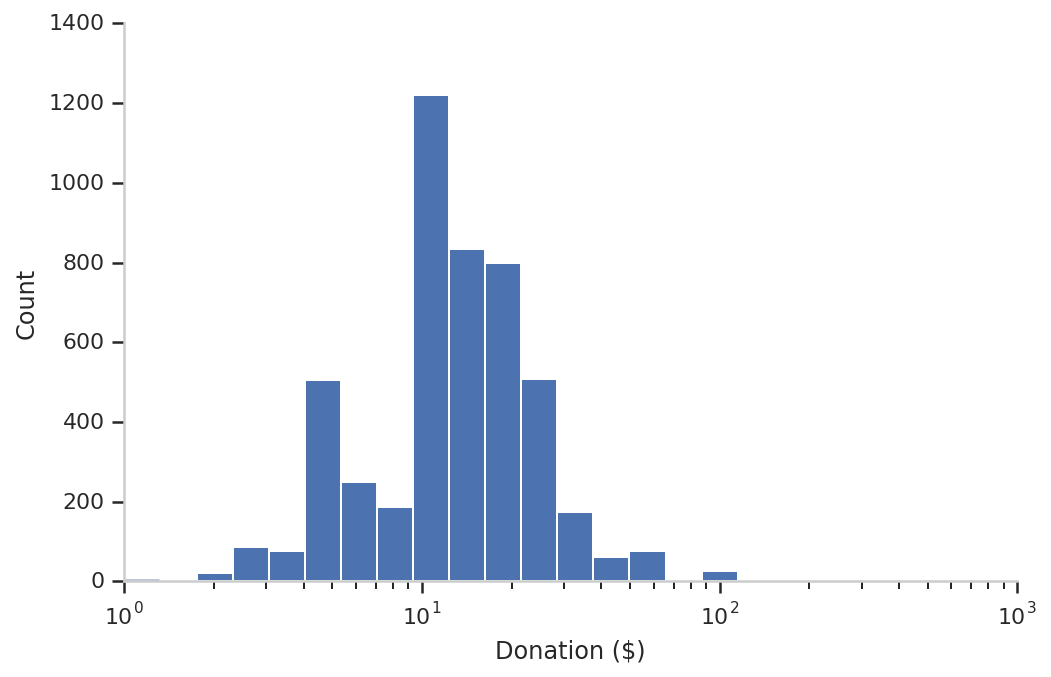

In [0]:
plot_hist_log_scale(y[y>0])

## Preprocess features

### Vocab

In [0]:
VOCAB_FEATURES = [
    'ODATEDW',  # date of donor's first gift (YYMM)
    'OSOURCE',  # donor acquisition mailing list
    'TCODE',    # donor title code
    'STATE',
    'ZIP',
    'DOMAIN',   # urbanicity level and socio-economic status of the neighborhood
    'CLUSTER',  # socio-economic status
    'GENDER',
    'MAXADATE', # date of the most recent promotion received
    'MINRDATE',
    'LASTDATE',
    'FISTDATE',
    'RFA_2A',
]

In [0]:
df['ODATEDW'] = df['ODATEDW'].astype('str')
df['TCODE'] = df['TCODE'].apply(
    lambda x: '{:03d}'.format(x // 1000 if x > 1000 else x))
df['ZIP'] = df['ZIP'].str.slice(0, 5)
df['MAXADATE'] = df['MAXADATE'].astype('str')
df['MINRDATE'] = df['MINRDATE'].astype('str')
df['LASTDATE'] = df['LASTDATE'].astype('str')
df['FISTDATE'] = df['FISTDATE'].astype('str')

In [0]:
def label_encoding(y, frequency_threshold=100):
  value_counts = pd.value_counts(y)
  categories = value_counts[
      value_counts >= frequency_threshold].index.to_numpy()
  # 0 indicates the unknown category.
  return pd.Categorical(y, categories=categories).codes + 1

In [0]:
for key in VOCAB_FEATURES:
  df[key] = label_encoding(df[key])

### Indicator

In [0]:
MAIL_ORDER_RESPONSES = [
    'MBCRAFT',
    'MBGARDEN',
    'MBBOOKS',
    'MBCOLECT',
    'MAGFAML',
    'MAGFEM',
    'MAGMALE',
    'PUBGARDN',
    'PUBCULIN',
    'PUBHLTH',
    'PUBDOITY',
    'PUBNEWFN',
    'PUBPHOTO',
    'PUBOPP',
    'RFA_2F',
]

In [0]:
INDICATOR_FEATURES = [
    'AGE',  # age decile, 0 indicates unknown
    'NUMCHLD',
    'INCOME',
    'WEALTH1',
    'HIT',
] + MAIL_ORDER_RESPONSES

In [0]:
df['AGE'] = pd.qcut(df['AGE'].values, 10).codes + 1
df['NUMCHLD'] = df['NUMCHLD'].apply(lambda x: 0 if np.isnan(x) else int(x))
df['INCOME'] = df['INCOME'].apply(lambda x: 0 if np.isnan(x) else int(x))
df['WEALTH1'] = df['WEALTH1'].apply(lambda x: 0 if np.isnan(x) else int(x) + 1)
df['HIT'] = pd.qcut(df['HIT'].values, q=50, duplicates='drop').codes

for col in MAIL_ORDER_RESPONSES:
  df[col] = pd.qcut(df[col].values, q=20, duplicates='drop').codes + 1

### Numeric

In [0]:
NUMERIC_FEATURES = [
    # binary
    'MAILCODE',  # bad address
    'NOEXCH',    # do not exchange
    'RECINHSE',  # donor has given to PVA's in house program
    'RECP3',     # donor has given to PVA's P3 program
    'RECPGVG',   # planned giving record
    'RECSWEEP',  # sweepstakes record
    'HOMEOWNR',  # home owner
    'CHILD03',
    'CHILD07',
    'CHILD12',
    'CHILD18',

    # continuous
    'CARDPROM',
    'NUMPROM',
    'CARDPM12',
    'NUMPRM12',
    'RAMNTALL',
    'NGIFTALL',
    'MINRAMNT',
    'MAXRAMNT',
    'LASTGIFT',
    'AVGGIFT',
]

In [0]:
df['MAILCODE'] = (df['MAILCODE'] == 'B').astype('float32')
df['PVASTATE'] = df['PVASTATE'].isin(['P', 'E']).astype('float32')
df['NOEXCH'] = df['NOEXCH'].isin(['X', '1']).astype('float32')
df['RECINHSE'] = (df['RECINHSE'] == 'X').astype('float32')
df['RECP3'] = (df['RECP3'] == 'X').astype('float32')
df['RECPGVG'] = (df['RECPGVG'] == 'X').astype('float32')
df['RECSWEEP'] = (df['RECSWEEP'] == 'X').astype('float32')
df['HOMEOWNR'] = (df['HOMEOWNR'] == 'H').astype('float32')
df['CHILD03'] = df['CHILD03'].isin(['M', 'F', 'B']).astype('float32')
df['CHILD07'] = df['CHILD07'].isin(['M', 'F', 'B']).astype('float32')
df['CHILD12'] = df['CHILD12'].isin(['M', 'F', 'B']).astype('float32')
df['CHILD18'] = df['CHILD18'].isin(['M', 'F', 'B']).astype('float32')

df['CARDPROM'] = df['CARDPROM'] / 100
df['NUMPROM'] = df['NUMPROM'] / 100
df['CARDPM12'] = df['CARDPM12'] / 100
df['NUMPRM12'] = df['NUMPRM12'] / 100
df['RAMNTALL'] = np.log1p(df['RAMNTALL'])
df['NGIFTALL'] = np.log1p(df['NGIFTALL'])
df['MINRAMNT'] = np.log1p(df['MINRAMNT'])
df['MAXRAMNT'] = np.log1p(df['MAXRAMNT'])
df['LASTGIFT'] = np.log1p(df['LASTGIFT'])
df['AVGGIFT'] = np.log1p(df['AVGGIFT'])

### All

In [0]:
CATEGORICAL_FEATURES = VOCAB_FEATURES + INDICATOR_FEATURES
ALL_FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES

## Train/eval split

In [0]:
def dnn_split(df):
  df_train = df.iloc[:num_train]
  df_eval = df.iloc[num_train:]

  def feature_dict(df):
    features = {k: v.values for k, v in dict(df[CATEGORICAL_FEATURES]).items()}
    features['numeric'] = df[NUMERIC_FEATURES].astype('float32').values
    return features

  x_train, y_train = feature_dict(df_train), df_train['TARGET_D'].astype(
      'float32').values
  x_eval, y_eval = feature_dict(df_eval), df_eval['TARGET_D'].astype(
      'float32').values

  return x_train, x_eval, y_train, y_eval

## Model

In [0]:
def embedding_dim(x):
  return int(x**.25) + 1


def embedding_layer(vocab_size):
  return tf.keras.Sequential([
      tf.keras.layers.Embedding(
          input_dim=vocab_size,
          output_dim=embedding_dim(vocab_size),
          input_length=1),
      tf.keras.layers.Flatten(),
  ])


def dnn_model(output_units):
  numeric_input = tf.keras.layers.Input(
      shape=(len(NUMERIC_FEATURES),), name='numeric')

  embedding_inputs = [
      tf.keras.layers.Input(shape=(1,), name=key, dtype=np.int64)
      for key in CATEGORICAL_FEATURES
  ]

  embedding_outputs = [
      embedding_layer(vocab_size=df[key].max() + 1)(input)
      for key, input in zip(CATEGORICAL_FEATURES, embedding_inputs)
  ]

  deep_input = tf.keras.layers.concatenate([numeric_input] + embedding_outputs)
  deep_model = tf.keras.Sequential([
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(units=output_units),
  ])
  return tf.keras.Model(
      inputs=[numeric_input] + embedding_inputs, outputs=deep_model(deep_input))

## Loss

In [0]:
if LOSS == 'mse':
  loss = tf.keras.losses.MeanSquaredError()
  output_units = 1

if LOSS == 'ziln':
  loss = ltv.zero_inflated_lognormal_loss
  output_units = 3

In [0]:
x_train, x_eval, y_train, y_eval = dnn_split(df)
model = dnn_model(output_units)

In [0]:
model.compile(optimizer=tf.keras.optimizers.Nadam(lr=LEARNING_RATE), loss=loss)

## Train

In [0]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
]

In [0]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=2048,
    epochs=200,
    verbose=2,
    callbacks=callbacks,
    validation_data=(x_eval, y_eval)).history

Train on 95412 samples, validate on 96367 samples
Epoch 1/200
95412/95412 - 4s - loss: 0.4750 - val_loss: 0.3570
Epoch 2/200
95412/95412 - 1s - loss: 0.3590 - val_loss: 0.3538
Epoch 3/200
95412/95412 - 1s - loss: 0.3547 - val_loss: 0.3549
Epoch 4/200
95412/95412 - 1s - loss: 0.3542 - val_loss: 0.3511
Epoch 5/200
95412/95412 - 1s - loss: 0.3509 - val_loss: 0.3704
Epoch 6/200
95412/95412 - 1s - loss: 0.3508 - val_loss: 0.3560
Epoch 7/200
95412/95412 - 1s - loss: 0.3488 - val_loss: 0.3560
Epoch 8/200
95412/95412 - 1s - loss: 0.3460 - val_loss: 0.3562
Epoch 9/200
95412/95412 - 1s - loss: 0.3449 - val_loss: 0.3505
Epoch 10/200
95412/95412 - 1s - loss: 0.3446 - val_loss: 0.3539
Epoch 11/200
95412/95412 - 1s - loss: 0.3413 - val_loss: 0.3563
Epoch 12/200
95412/95412 - 1s - loss: 0.3416 - val_loss: 0.3541
Epoch 13/200
95412/95412 - 1s - loss: 0.3410 - val_loss: 0.3528
Epoch 14/200
95412/95412 - 1s - loss: 0.3388 - val_loss: 0.3601
Epoch 15/200
95412/95412 - 1s - loss: 0.3398 - val_loss: 0.3578

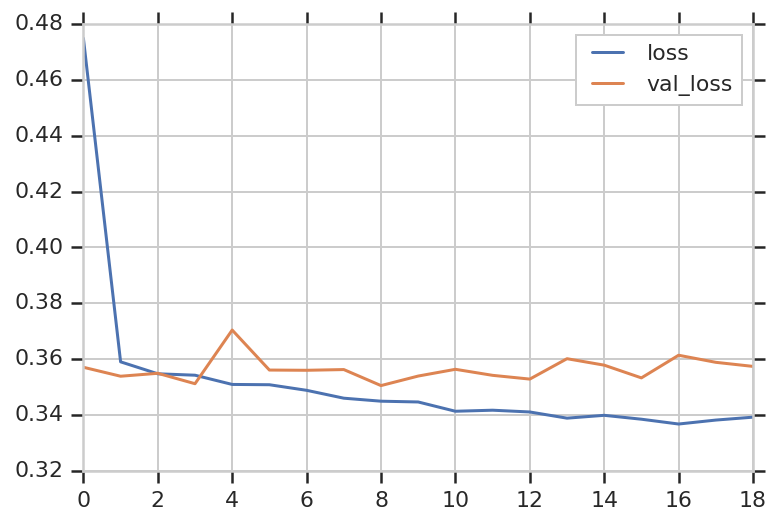

In [0]:
pd.DataFrame(history)[['loss', 'val_loss']].plot();

## Eval

In [0]:
if LOSS == 'mse':
  y_pred = model.predict(x=x_eval, batch_size=1024).flatten()

if LOSS == 'ziln':
  logits = model.predict(x=x_eval, batch_size=1024)
  y_pred = ltv.zero_inflated_lognormal_pred(logits).numpy().flatten()

### Total Profit

In [0]:
unit_costs = [0.4, 0.5, 0.6, 0.68, 0.7, 0.8, 0.9, 1.0]

In [0]:
num_mailed = [np.sum(y_pred > v) for v in unit_costs]
num_mailed

[79997, 68684, 57260, 48432, 46332, 36488, 27858, 20799]

In [0]:
baseline_total_profit = np.sum(y_eval - 0.68)
baseline_total_profit

10560.074

In [0]:
total_profits = [np.sum(y_eval[y_pred > v] - v) for v in unit_costs]
total_profits

[36429.336,
 27306.64,
 19300.139,
 14734.877,
 13681.24,
 9360.869,
 6448.3027,
 4785.0]

### Gini Coefficient

In [0]:
gain = pd.DataFrame({
    'lorenz': ltv.cumulative_true(y_eval, y_eval),
    'baseline': ltv.cumulative_true(y_eval, x_eval['numeric'][:, 19]),
    'model': ltv.cumulative_true(y_eval, y_pred),
})

In [0]:
num_customers = np.float32(gain.shape[0])
gain['cumulative_customer'] = (np.arange(num_customers) + 1.) / num_customers

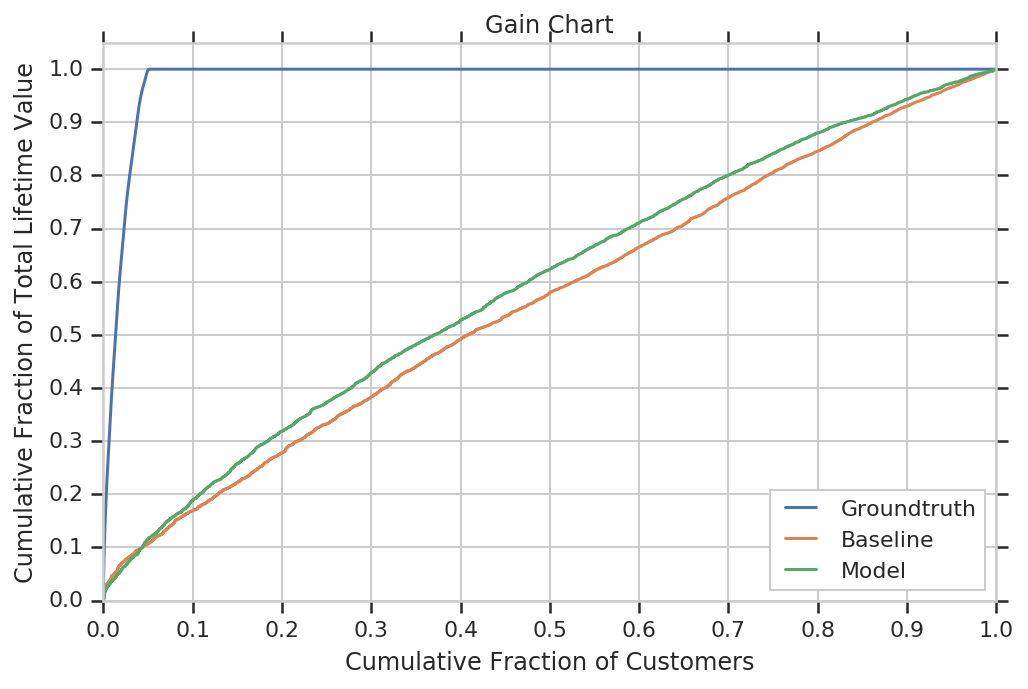

In [0]:
ax = gain[[
    'cumulative_customer',
    'lorenz',
    'baseline',
    'model',
]].plot(
    x='cumulative_customer', figsize=(8, 5), legend=True)

ax.legend(['Groundtruth', 'Baseline', 'Model'], loc='lower right')

ax.set_xlabel('Cumulative Fraction of Customers')
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_xlim((0, 1.))

ax.set_ylabel('Cumulative Fraction of Total Lifetime Value')
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim((0, 1.05))
ax.set_title('Gain Chart');

In [0]:
gini = ltv.gini_from_gain(gain[['lorenz', 'baseline', 'model']])
gini

,raw,normalized
lorenz,0.967057,1.000000
baseline,0.125138,0.129401
model,0.188237,0.194649


### Calibration

In [0]:
df_decile = ltv.decile_stats(y_eval, y_pred)
df_decile

,label_mean,normalized_mae,normalized_rmse,pred_mean,decile_mape
decile,,,,,
0,0.446768,1.518032,6.234249,0.253326,0.432981
1,0.500363,1.696175,5.785942,0.379958,0.240635
2,0.629462,1.669090,5.069715,0.468928,0.255034
3,0.708779,1.699808,5.270791,0.552951,0.219853
4,0.687195,1.835328,5.020494,0.638257,0.071215
5,0.760416,1.862291,5.044576,0.729008,0.041303
6,0.781443,1.955214,4.946170,0.830943,0.063344
7,0.863117,1.991613,5.550368,0.952045,0.103030
8,1.025578,1.967602,4.842186,1.119715,0.091788


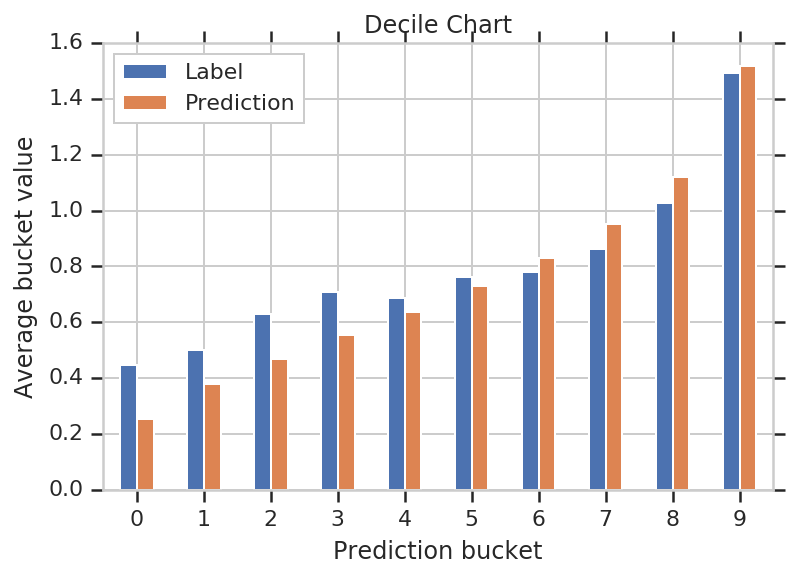

In [0]:
ax = df_decile[['label_mean', 'pred_mean']].plot.bar(rot=0)

ax.set_title('Decile Chart')
ax.set_xlabel('Prediction bucket')
ax.set_ylabel('Average bucket value')
ax.legend(['Label', 'Prediction'], loc='upper left');

### Rank Correlation

In [0]:
def spearmanr(
    x1: Sequence[float],
    x2: Sequence[float]) -> float:
  """Calculates spearmanr rank correlation coefficient.

  See https://docs.scipy.org/doc/scipy/reference/stats.html.

  Args:
    x1: 1D array_like.
    x2: 1D array_like.

  Returns:
    correlation: float.
  """
  return stats.spearmanr(x1, x2, nan_policy='raise')[0]


spearman_corr = spearmanr(y_eval, y_pred)
spearman_corr

0.022891050334413545

### All metrics together

In [0]:
df_metrics = pd.DataFrame({
    'model': MODEL,
    'loss_function': LOSS,
    'train_loss': history['loss'][-1],
    'eval_loss': history['val_loss'][-1],
    'label_positive': np.mean(y_eval > 0),
    'label_mean': y_eval.mean(),
    'pred_mean': y_pred.mean(),
    'decile_mape': df_decile['decile_mape'].mean(),
    'baseline_gini': gini['normalized'][1],
    'gini': gini['normalized'][2],
    'spearman_corr': spearman_corr,
}, index=[VERSION])

In [0]:
for unit_cost, total_profit in zip(unit_costs, total_profits):
  df_metrics['total_profit_{:02d}'.format(int(unit_cost * 100))] = total_profit

In [0]:
df_metrics.T

,0
baseline_gini,0.129401
decile_mape,0.153559
eval_loss,0.357348
gini,0.194649
label_mean,0.789582
label_positive,0.0505671
loss_function,ziln
model,dnn
pred_mean,0.744231
spearman_corr,0.0228911


## Save

In [0]:
output_path = OUTPUT_CSV_FOLDER

In [0]:
if not os.path.isdir(output_path):
  os.makedirs(output_path)

In [0]:
output_file = os.path.join(output_path, '{}_regression_{}_{}.csv'.format(MODEL, LOSS, VERSION))

In [0]:
df_metrics.to_csv(output_file, index=False)